In [1]:
import os.path
import logging
import time
import torch
import torch.nn.utils.prune as prune
import numpy as np

from torch.autograd import Variable
from PIL import Image
from collections import OrderedDict
from pathlib import Path
from tqdm import tqdm

from MSRResNet.utils import utils_logger
from MSRResNet.utils import utils_image as util
from MSRResNet.SRResNet import MSRResNet, PrunedMSRResNet
from CARN import CARN
from srdensenet import Net as SRDenseNet


def get_logger(name):
    # Set logger
    utils_logger.logger_info(name, log_path=f'{name}.log')
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)
    return logger

def count_num_of_parameters(model):
    number_parameters = sum(map(lambda x: x.numel(), model.parameters()))
    return number_parameters

def test(model, L_folder, out_folder, logger, save):
    # --------------------------------
    # read image
    # --------------------------------
    util.mkdir(out_folder)

    # record PSNR, runtime
    test_results = OrderedDict()
    test_results['runtime'] = []

    logger.info(L_folder)
    logger.info(out_folder)
    idx = 0

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    for img in util.get_image_paths(L_folder):

        # --------------------------------
        # (1) img_L
        # --------------------------------
        idx += 1
        img_name, ext = os.path.splitext(os.path.basename(img))
        logger.info('{:->4d}--> {:>10s}'.format(idx, img_name+ext))

        img_L = util.imread_uint(img, n_channels=3)
        img_L = util.uint2tensor4(img_L)
        img_L = img_L.to(device)

        start.record()
        img_E = model(img_L)
        end.record()
        torch.cuda.synchronize()
        test_results['runtime'].append(start.elapsed_time(end))  # milliseconds

        # --------------------------------
        # (2) img_E
        # --------------------------------
        img_E = util.tensor2uint(img_E)

        if save:
            new_name = '{:3d}'.format(int(img_name.split('x')[0]))
            path = os.path.join(out_folder, new_name+ext)
            logger.info('Save {:4d} to {:10s}'.format(idx, path))
            util.imsave(img_E, path)
    ave_runtime = sum(test_results['runtime']) / len(test_results['runtime']) / 1000.0
    logger.info('------> Average runtime of ({}) is : {:.6f} seconds'.format(L_folder, ave_runtime))

def _load_img_array(path, color_mode='RGB',
                    channel_mean=None, modcrop=[0, 0, 0, 0]):
    '''Load an image using PIL and convert it into specified color space,
    and return it as an numpy array.
    https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py
    The code is modified from Keras.preprocessing.image.load_img, img_to_array.
    '''
    # Load image
    img = Image.open(path)
    if color_mode == 'RGB':
        cimg = img.convert('RGB')
        x = np.asarray(cimg, dtype='float32')
    elif color_mode == 'YCbCr' or color_mode == 'Y':
        cimg = img.convert('YCbCr')
        x = np.asarray(cimg, dtype='float32')
        if color_mode == 'Y':
            x = x[:, :, 0:1]
    # Normalize To 0-1
    x *= 1.0 / 255.0
    if channel_mean:
        x[:, :, 0] -= channel_mean[0]
        x[:, :, 1] -= channel_mean[1]
        x[:, :, 2] -= channel_mean[2]
    if modcrop[0] * modcrop[1] * modcrop[2] * modcrop[3]:
        x = x[modcrop[0]:-modcrop[1], modcrop[2]:-modcrop[3], :]
    return x

def _rgb2ycbcr(img, maxVal=255):
    # Same as MATLAB's rgb2ycbcr
    # Updated at 03/14/2017
    # Not tested for cb and cr
    O = np.array([[16],
                  [128],
                  [128]])
    T = np.array([[0.256788235294118, 0.504129411764706, 0.097905882352941],
                  [-0.148223529411765, -0.290992156862745, 0.439215686274510],
                  [0.439215686274510, -0.367788235294118, -0.071427450980392]])
    if maxVal == 1:
        O = O / 255.0
    t = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))
    t = np.dot(t, np.transpose(T))
    t[:, 0] += O[0]
    t[:, 1] += O[1]
    t[:, 2] += O[2]
    ycbcr = np.reshape(t, [img.shape[0], img.shape[1], img.shape[2]])
    return ycbcr

def psnr(y_true, y_pred, shave_border=4):
    '''
        Input must be 0-255, 2D
    '''
    target_data = np.array(y_true, dtype=np.float32)
    ref_data = np.array(y_pred, dtype=np.float32)
    diff = ref_data - target_data
    if shave_border > 0:
        diff = diff[shave_border:-shave_border, shave_border:-shave_border]
    rmse = np.sqrt(np.mean(np.power(diff, 2)))
    return 20 * np.log10(255. / rmse)

def calculate_psnr(testsets_H, testset_O, logger):
    count = 0
    avg_psnr_value = 0.0
    h_list = sorted(list(Path(testsets_H).glob('*.png')))
    o_list = sorted(list(Path(testset_O).glob('*.png')))
    for h_path, o_path in tqdm(zip(h_list, o_list)):
        with torch.no_grad():
            # Load label image
            h_img = _load_img_array(h_path)
            h_img = (h_img * 255).astype(np.uint8)
            # Load output image
            o_img = _load_img_array(o_path)
            o_img = (o_img * 255).astype(np.uint8)
            # Get psnr of bicubic, predicted
            psnr_value = psnr(_rgb2ycbcr(h_img)[:, :, 0],
                              _rgb2ycbcr(o_img)[:, :, 0],
                              4)
            count += 1
            avg_psnr_value += psnr_value
    return (avg_psnr_value / count)

# Initialize variables
data_dir='../dataset'
root_dir='MSRResNet'
save=False
# --------------------------------
# basic settings
# --------------------------------
testsets = f'{data_dir}/DIV2K'
testset_L = f'DIV2K_valid_LR_bicubic'
testset_H = f'DIV2K_valid_HR'
L_folder = os.path.join(testsets, testset_L, 'X4')
H_folder = os.path.join(testsets, testset_H)
E_folder = os.path.join('results')
P_folder = os.path.join('pruned')
torch.cuda.current_device()
torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger = get_logger('AIM-track')
#model_path = os.path.join(root_dir, 'MSRResNetx4_model', 'MSRResNetx4.pth')
#model_name = 'MSRResNet'
model_name = 'CARN'
model_path = os.path.join('CARN', 'CARN_model', 'v2_e10000.pth')#'carn.pth')
rewind_path = os.path.join('CARN', 'CARN_model', 'v2_e0.pth')
#model_name = 'PCARN32'
#model_path = os.path.join('CARN', 'CARN_model', 'v8_e8000.pth')#'carn.pth')
#model_path = os.path.join('srdensenet_v0.pth')
#model_name = 'SRDenseNet'
#model_path = os.path.join(root_dir, 'MSRResNetx4_model', 'PrunedMSRResNetx4_v2_10000.pth')
#rewind_path = os.path.join(root_dir, 'MSRResNetx4_model', 'PrunedMSRResNetx4_v2_0.pth')
#model_name = 'MSRResNet'

LogHandlers setup!


In [2]:
def load_model(model_path, device, name='MSRResNet'):
    # --------------------------------
    # load model
    # --------------------------------
    if name == 'MSRResNet':
        model = MSRResNet(in_nc=3, out_nc=3, nf=64, nb=16, upscale=4)
        model.load_state_dict(torch.load(model_path), strict=True)
        model.eval()
        for k, v in model.named_parameters():
            v.requires_grad = False
        model = model.to(device)
        return model
    elif name == 'PMSRResNet':
        model = torch.nn.DataParallel(PrunedMSRResNet())
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['net'], strict=True)
        model.eval()
        for k, v in model.named_parameters():
            v.requires_grad = False
        model = model.to(device)
        return model
    elif name == 'CARN':
        model = torch.nn.DataParallel(CARN(multi_scale=4, group=1))
        # Load pretrained model
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['net'])
        # Return net
        model.eval()
        for k, v in model.named_parameters():
            v.requires_grad = False
        model = model.to(device)
        return model
    elif name == 'PCARN':
        model = CARN(multi_scale=4, group=1, channel_cnt=12)
        # Load pretrained model
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['net'])
        # Return net
        model.eval()
        for k, v in model.named_parameters():
            v.requires_grad = False
        model = model.to(device)
        return model
    elif name == 'PCARN32':
        model = torch.nn.DataParallel(CARN(multi_scale=4, group=1, channel_cnt=32))
        # Load pretrained model
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['net'])
        # Return net
        model.eval()
        for k, v in model.named_parameters():
            v.requires_grad = False
        model = model.to(device)
        modle = model.module
        return model
    elif name == 'SRDenseNet':
        model = torch.load(model_path)['model']
        # Return net
        model.eval()
        for k, v in model.named_parameters():
            v.requires_grad = False
        model = model.to(device)
        return model

model = load_model(model_path, device, model_name)
logger.info(f'Params number: {count_num_of_parameters(model)}')

20-07-06 09:07:02.428 : Params number: 1591963


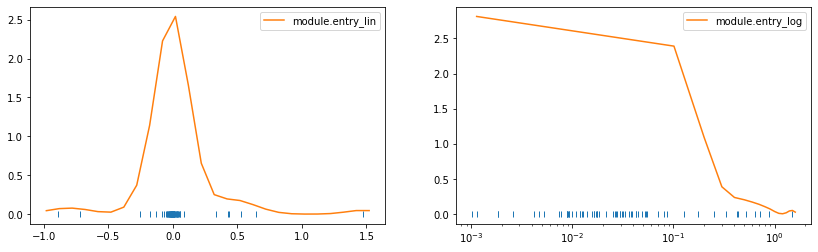

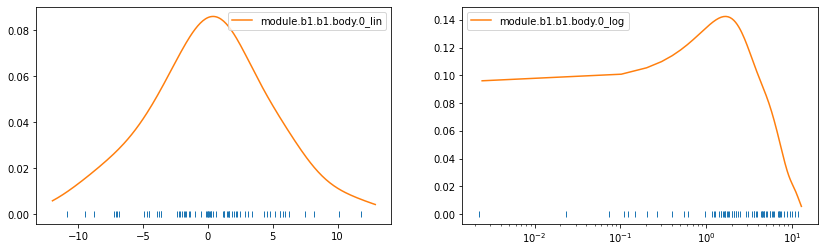

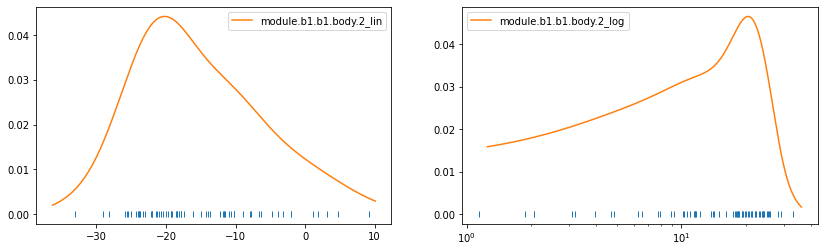

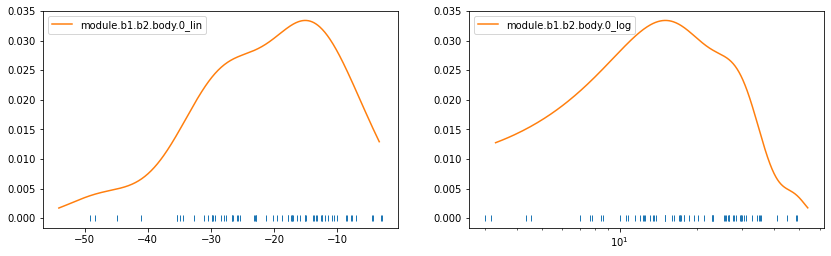

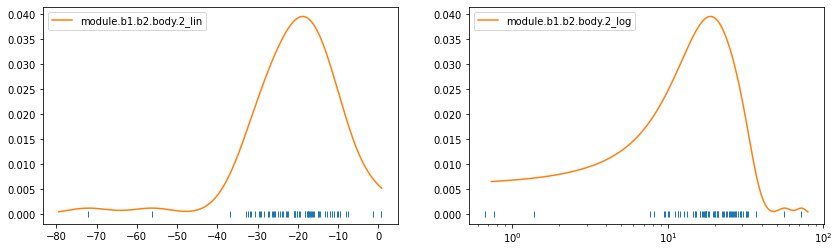

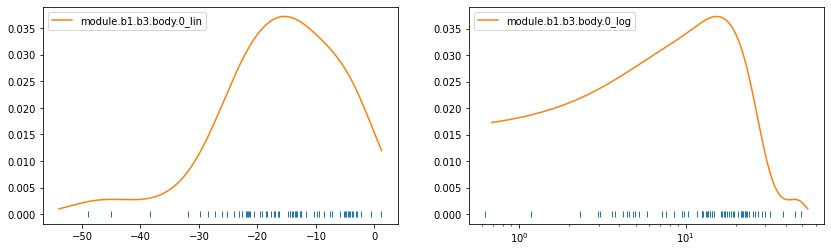

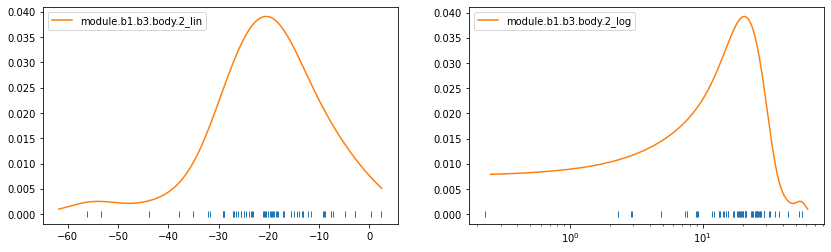

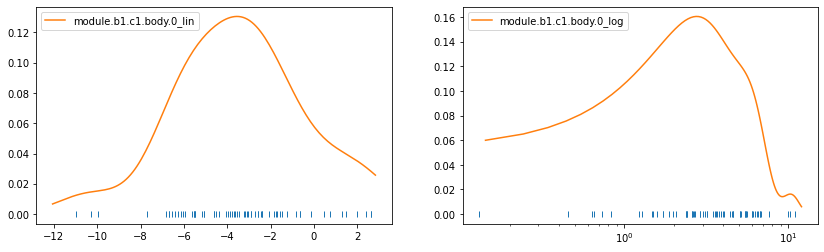

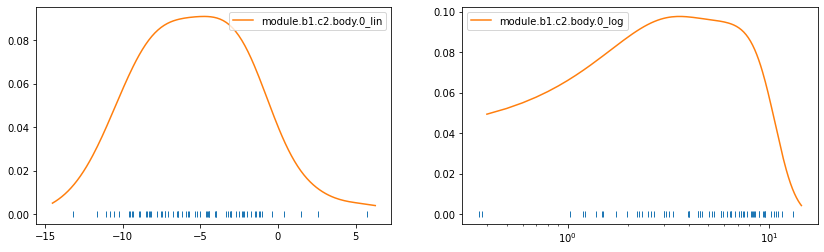

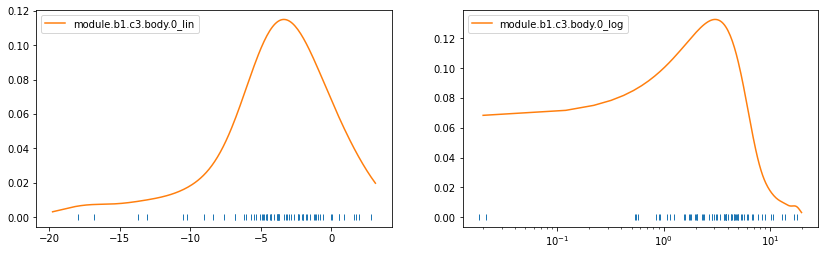

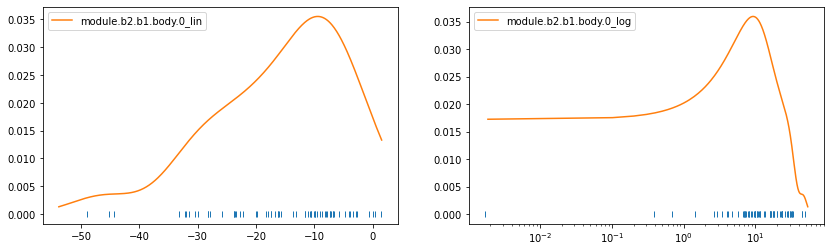

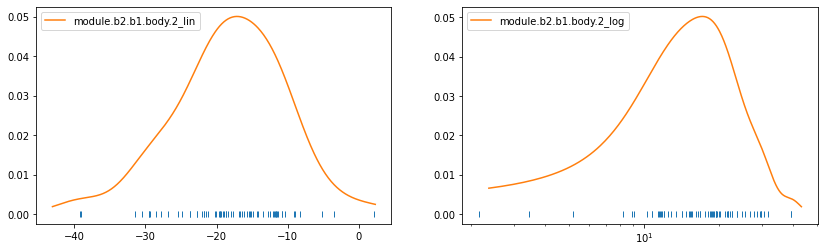

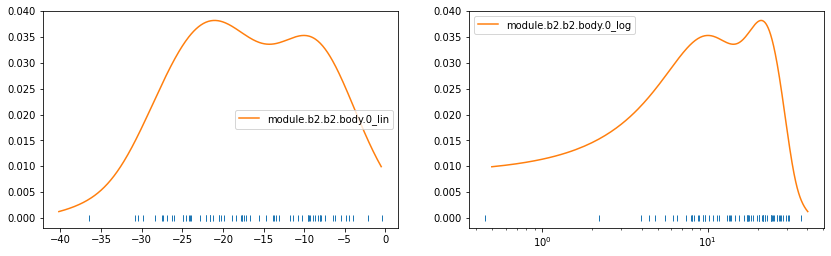

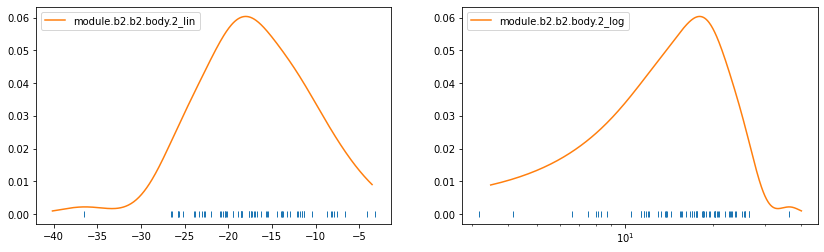

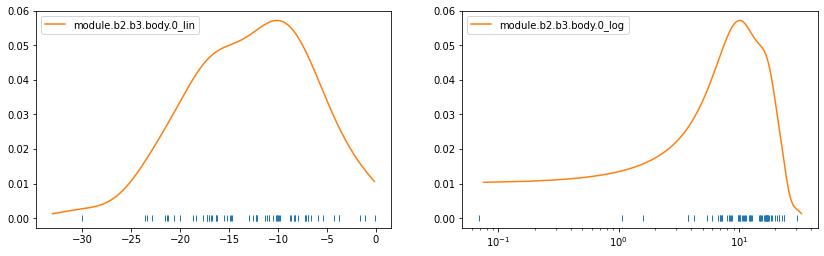

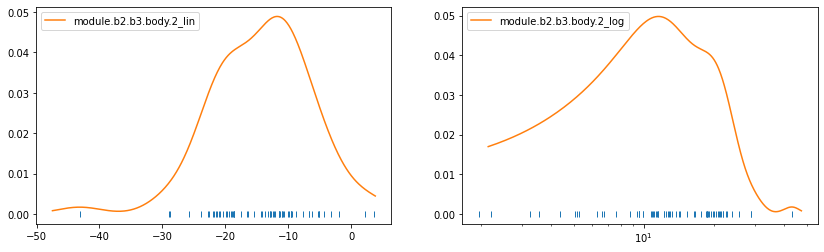

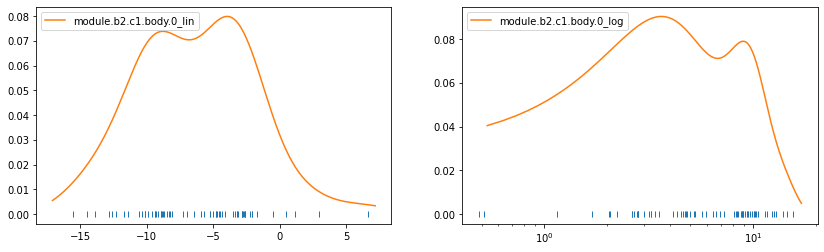

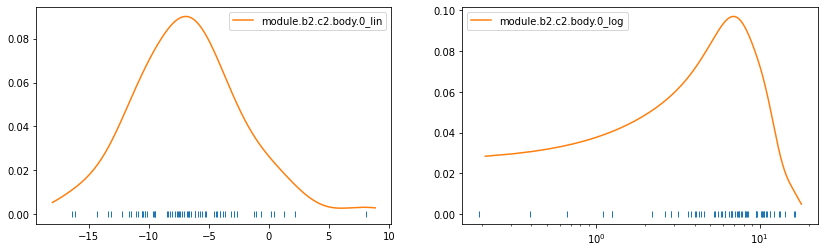

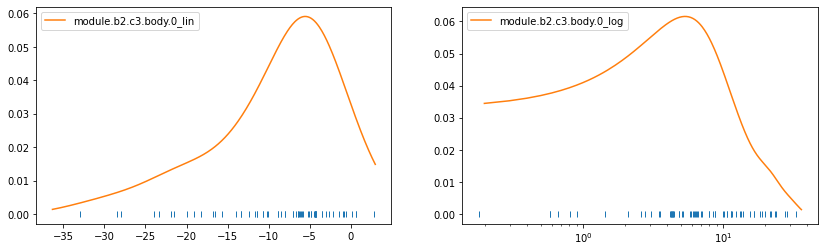

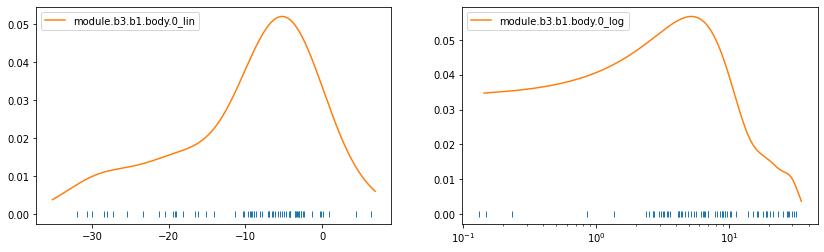

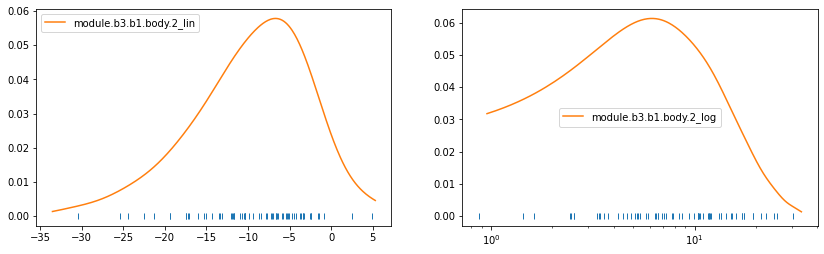

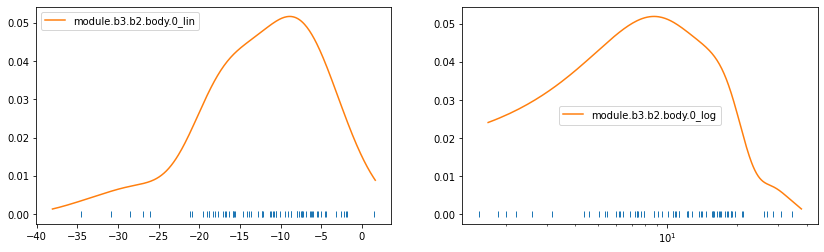

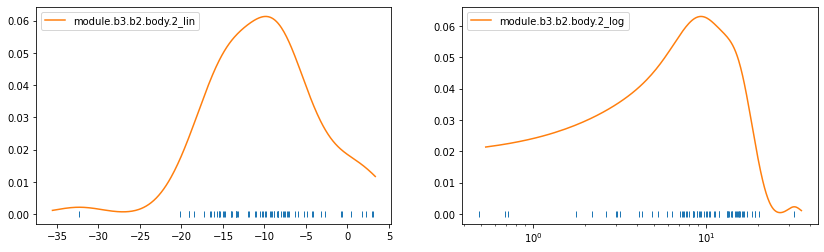

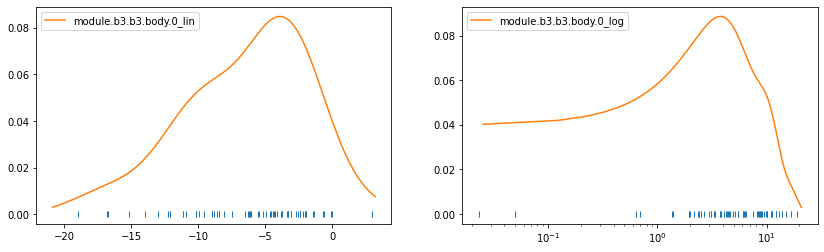

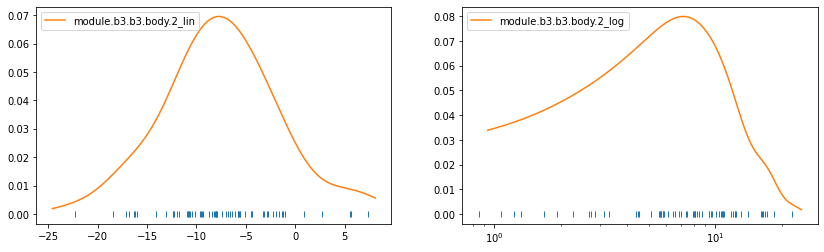

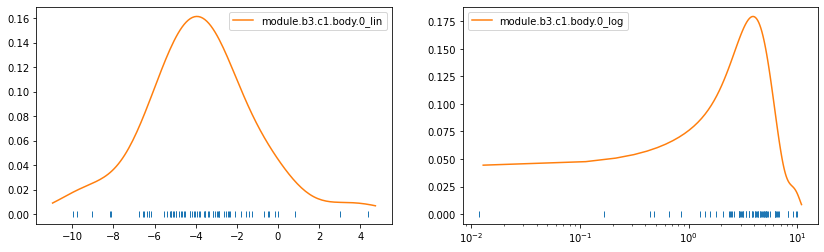

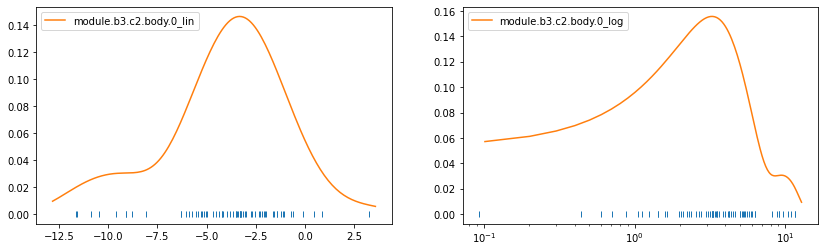

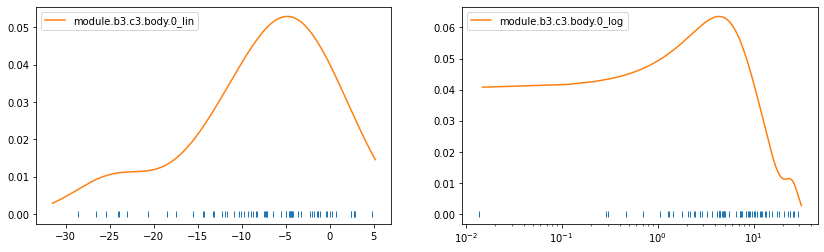

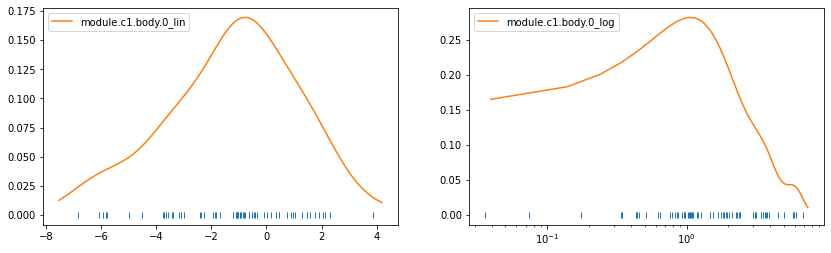

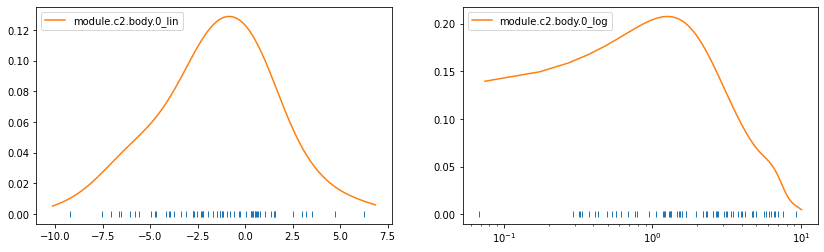

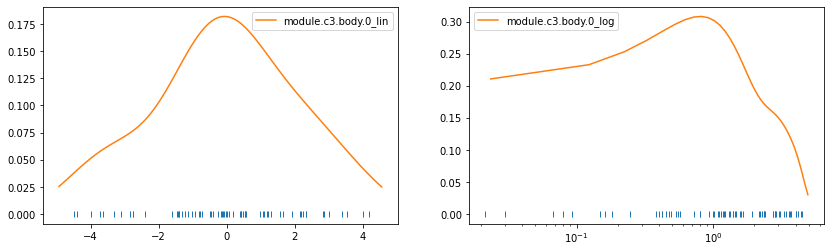

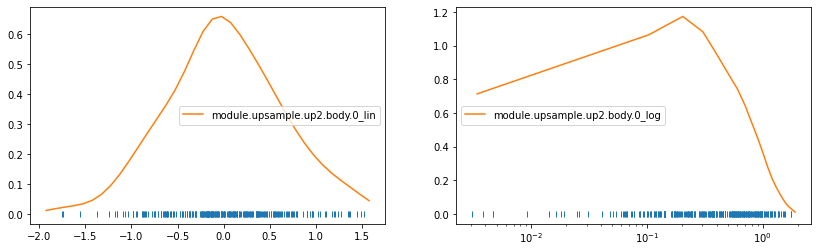

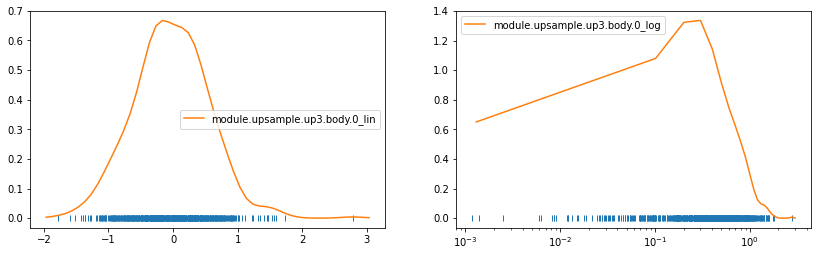

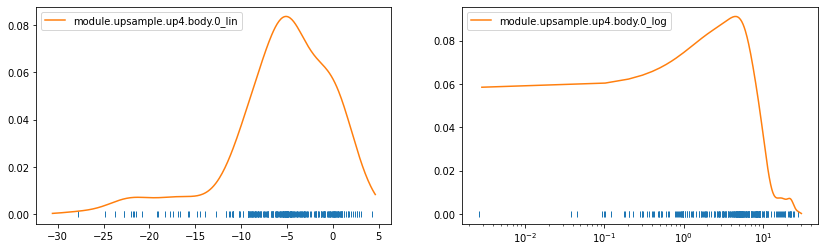

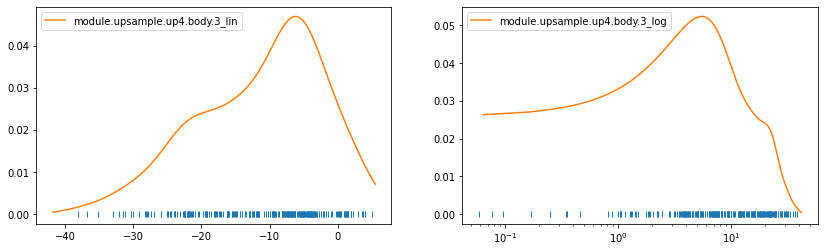

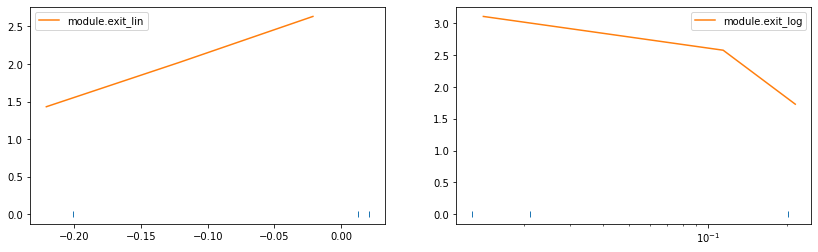

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import TSNE
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (14,4)

def visualize_both(name, norm):
    fig, ax = plt.subplots(1, 2)
    ax[0].set_xscale('linear')
    visualize_norm_stat(f"{name}_lin", norm, ax[0])
    ax[1].set_xscale('log')
    visualize_norm_stat(f"{name}_log", norm.abs(), ax[1])
    plt.show()
    #plt.savefig(f"images/{name}.png", dpi=300)

def visualize_norm_stat(name, norm, ax):
    # Draw each point
    y = np.zeros(np.shape(norm))
    ax.plot(norm, y, '|')
    estimator = stats.gaussian_kde(norm, bw_method='silverman')
    # Draw kernel density estimate
    X = np.arange(norm.min() * 1.1, norm.max() * 1.1, 0.1)
    K = estimator(X)
    ax.plot(X, K, label=f'{name}')
    # Set other things
    ax.legend(loc='best')

filter_unprune = ['module.sub_mean.shifter', 'module.add_mean.shifter']
for name, module in model.named_modules():
    module_name = type(module).__name__
    unprune = 'Conv2d' not in module_name or name in filter_unprune
    if unprune: continue
    visualize_both(name, module.weight.sum(-1).sum(-1).sum(-1).detach().cpu())

In [ ]:
test(model, L_folder, E_folder, logger, True)
logger.info(f'PSNR before pruning {calculate_psnr(H_folder, E_folder, logger)}')

In [ ]:
# Prune CARN
import copy
from collections import OrderedDict

model_new = copy.deepcopy(model)
model_new = model_new.module
# Kind of filter
filter_unprune = ['sub_mean.shifter', 'add_mean.shifter']
# Pruning!
mask_dict = OrderedDict()
logger.info('Params number(Before prune): {}'.format(count_num_of_parameters(model_new)))
for name, module in model_new.named_modules():
    # Prune or not
    module_name = type(module).__name__
    unprune = 'Conv2d' not in module_name or name in filter_unprune
    logger.debug("=" * 20)
    logger.debug(f"{name}, {module_name}: Prune-{not unprune}")
    if unprune: continue
    # Prepare pruning
    pre_module_weight_shape = module.weight.shape
    pre_module_bias_shape = module.bias.shape
    # Prune in_channel
    in_channel_mask = None
    name_splited = name.split('.')
    if len(name_splited) == 3 and name_splited[0][0] == 'c':
        logger.debug(f"outside: {name_splited}")
        i1 = int(name_splited[0][-1])
        i3 = int(name_splited[-1])
        mask_list = []
        if i1 == 1:
            mask_list.append(mask_dict['entry'])
        elif i1 > 1:
            mask_list.append(mask_dict[f'b{i1 - 1}.c3.body.0'])   # previous b
        for x in range(1, i1):
            mask_list.append(mask_dict[f'b{x}.c3.body.0'])    # previous c
        in_channel_mask = torch.cat(mask_list)
        logger.debug(f"Concat previous c and b: {in_channel_mask.shape}")
    elif len(name_splited) == 4 and name_splited[1][0] == 'c':
        logger.debug(f"inside: {name_splited}")
        i1 = int(name_splited[0][-1])
        i2 = int(name_splited[1][-1])
        i4 = int(name_splited[-1])
        mask_list = []
        if i1 == 1:
            mask_list.append(mask_dict['entry'])              # First
        elif i1 > 1:
            mask_list.append(mask_dict[f'b{i1 - 1}.c3.body.0'])              # First
        for x in range(1, i2):
            mask_list.append(mask_dict[f'b{i1}.b{x}.body.{i4}']) # previous c
        mask_list.append(mask_dict[f'b{i1}.b{i2}.body.{i4}'])    # previous b
        in_channel_mask = torch.cat(mask_list)
        logger.debug(f"Concat previous c and b: {in_channel_mask.shape}")
    elif mask_dict and name not in ['entry']:
        last_name, in_channel_mask = list(mask_dict.items())[-1]
        logger.debug(f"Use last mask: {last_name}, {in_channel_mask.shape}")
    else:
        in_channel_mask = torch.ones(module.weight.shape[1], dtype=torch.bool).to(device)
        logger.debug(f"No in_channel pruning with {in_channel_mask.shape}")
    module.weight = torch.nn.Parameter(module.weight[:, in_channel_mask])
    # Get pruning mask
    prune.ln_structured(module, 'weight', amount=0.8125, n=2, dim=0)
    prune.remove(module, 'weight')
    out_channel_mask = module.weight.sum(-1).sum(-1).sum(-1) != 0
    mask_dict[name] = out_channel_mask
    # Prune out_channel
    if name in ['exit']:
        logger.debug(f"No out_channel pruning with {out_channel_mask.shape}")
    else:
        module.weight = torch.nn.Parameter(module.weight[out_channel_mask, :])
        module.bias = torch.nn.Parameter(module.bias[out_channel_mask])
    logger.debug(f"mask_index.shape: {out_channel_mask.shape}")
    logger.debug(f"module.weight.shape: {pre_module_weight_shape} --> {module.weight.shape}")
    logger.debug(f"module.bias.shape: {pre_module_bias_shape} --> {module.bias.shape}")
logger.info('Params number(After prune): {}'.format(count_num_of_parameters(model_new)))
logger.info('mask dict')
for k, v in mask_dict.items():
    logger.debug(f"{k}: {v.shape}")

In [ ]:
# Prune CARN naively
import copy
from collections import OrderedDict

rewind_model = load_model(rewind_path, device, model_name)
rewind_model = rewind_model.module
model_new = copy.deepcopy(model)
model_new = model_new.module
# Kind of filter
filter_unprune = ['sub_mean.shifter', 'add_mean.shifter']
# Pruning!
mask_dict = OrderedDict()
logger.info('Params number(Before prune): {}'.format(count_num_of_parameters(model_new)))
for name, module in model_new.named_modules():
    # Prune or not
    module_name = type(module).__name__
    unprune = 'Conv2d' not in module_name or name in filter_unprune
    logger.debug("=" * 20)
    logger.debug(f"{name}, {module_name}: Prune-{not unprune}")
    if unprune: continue
    # Prepare pruning
    rewind_module = None
    for n, m in rewind_model.named_modules():
        if name == n:
            rewind_module = m
            break
    pre_module_weight_shape = module.weight.shape
    pre_module_bias_shape = module.bias.shape
    # Prune in_channel
    if name not in ['entry']:
        temp_module = copy.deepcopy(module)
        prune.ln_structured(temp_module, 'weight', amount=0.90625, n=2, dim=1)
        prune.remove(temp_module, 'weight')
        in_channel_mask = temp_module.weight.sum(-1).sum(-1).sum(0) != 0
    else:
        in_channel_mask = torch.ones(module.weight.shape[1], dtype=torch.bool).to(device)
    # Prune out_channel
    if name not in ['exit']:
        temp_module = copy.deepcopy(module)
        prune.ln_structured(temp_module, 'weight', amount=0.90625, n=2, dim=0)
        prune.remove(temp_module, 'weight')
        out_channel_mask = temp_module.weight.sum(-1).sum(-1).sum(-1) != 0
    else:
        out_channel_mask = torch.ones(module.weight.shape[0], dtype=torch.bool).to(device)
    module.weight = torch.nn.Parameter(rewind_module.weight[:, in_channel_mask])
    module.weight = torch.nn.Parameter(module.weight[out_channel_mask, :])
    module.bias = torch.nn.Parameter(rewind_module.bias[out_channel_mask])
    logger.debug(f"mask_index.shape: {out_channel_mask.shape}")
    logger.debug(f"module.weight.shape: {pre_module_weight_shape} --> {module.weight.shape}")
    logger.debug(f"module.bias.shape: {pre_module_bias_shape} --> {module.bias.shape}")
logger.info('Params number(After prune): {}'.format(count_num_of_parameters(model_new)))

In [ ]:
# Prune MSRResNet

import copy

model_new = copy.deepcopy(model)
logger.info('Params number(Before prune): {}'.format(count_num_of_parameters(model_new)))
pre_mask_index = torch.ones(3, dtype=torch.bool).to(device)
conv_first_mask_index = None
for name, module in model_new.named_modules():
    if 'conv' in name:
        if name == 'upconv2':
            logger.debug("=" * 20)
            logger.debug(f"{name}: Unpruned")
            continue
        # DEBUG ----------------------------------------------------
        logger.debug("=" * 20)
        logger.debug(f"{name}: Pruned")
        pre_module_weight_shape = module.weight.shape
        pre_module_bias_shape = module.bias.shape
        # DEBUG ----------------------------------------------------
        # Prune in_channel
        if name == 'upconv1':
            logger.debug(f"conv_first_mask_index.shape: {conv_first_mask_index.shape}")
            module.weight = torch.nn.Parameter(module.weight[:, conv_first_mask_index])
            # DEBUG ----------------------------------------------------
            logger.debug(f"mask_index.shape: {mask_index.shape}")
            logger.debug(f"module.weight.shape: {pre_module_weight_shape} --> {module.weight.shape}")
            logger.debug(f"module.bias.shape: {pre_module_bias_shape} --> {module.bias.shape}")
            # DEBUG ----------------------------------------------------
            continue
        if name not in ['conv_first', 'HRconv']: # Without first
            logger.debug(f"pre_mask_index.shape: {pre_mask_index.shape}")
            module.weight = torch.nn.Parameter(module.weight[:, pre_mask_index])
        # Get pruning mask
        prune.ln_structured(module, 'weight', amount=0.9, n=2, dim=0)
        prune.remove(module, 'weight')
        mask_index = module.weight.sum(-1).sum(-1).sum(-1) != 0
        pre_mask_index = mask_index
        if name == 'conv_first':
            conv_first_mask_index = mask_index
        # Prune out_channel
        if name not in ['conv_last']: # Without last
            module.weight = torch.nn.Parameter(module.weight[mask_index, :])
            module.bias = torch.nn.Parameter(module.bias[mask_index])
            # DEBUG ----------------------------------------------------
            logger.debug(f"mask_index.shape: {mask_index.shape}")
            logger.debug(f"module.weight.shape: {pre_module_weight_shape} --> {module.weight.shape}")
            logger.debug(f"module.bias.shape: {pre_module_bias_shape} --> {module.bias.shape}")
            # DEBUG ----------------------------------------------------
    else:
        logger.debug("=" * 20)
        logger.debug(f"{name}: Unpruned")
logger.info('Params number(After prune): {}'.format(count_num_of_parameters(model_new)))

In [ ]:
test(model_new, L_folder, P_folder, logger, True)
#test(model, L_folder, P_folder, logger, True)
logger.info(f'PSNR after pruning {calculate_psnr(H_folder, P_folder, logger)}')

In [ ]:
pruned_model_path = "CARN/CARN_model/PrunedCARN_6_rewinded.pth"#"MSRResNet/MSRResNetx4_model/PrunedMSRResNetx4.pth"
torch.save({
    'net': model_new.state_dict()
}, pruned_model_path)